Name: **Muhammad Junaid Aftab**
UID:  **117396188**

# Homework 6:  Gradient methods and Duality

Put the file `utility.py` into your directory.  Then run the following cell.

In [1]:
from utility import *
import numpy as np
from numpy import sqrt, sum, abs, max, maximum, logspace, exp, log, log10, zeros
from numpy.linalg import norm
from numpy.random import randn, rand, normal, randint
import urllib
import matplotlib.pyplot as plt
from math import prod
from IPython.display import clear_output
np.random.seed(0)
def good_job(path):
    a = plt.imread(urllib.request.urlopen(path))
    fig = plt.imshow(a)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()
np.random.seed(0)

# Problem 1:  Gradient descent
Write a function that estimates the Lipschitz constant of a function $g$.  This can be done using the formula
$$L \approx \frac{\|g(x) - g(y)\|}{\|x-y\|}.$$
The inputs should be a function $g:\mathbb{R}^n \to \mathbb{R}^m,$ and an initial vector $x$ in the domain of $g$.

In [2]:
def estimate_lipschitz(g, x):
    
    n = prod(np.shape(x))
    delta = randn(n).reshape(np.shape(x))
    
    num = norm(g(x) - g(x+delta))
    den = norm(delta)
    L = num/den
        
    return L

#### Now, run this unit test

In [3]:
g = lambda x: 10*x
x = randn(3,4,5)
L = estimate_lipschitz(g,x)
assert abs(L-10)<1e-10, "Your Lipschitz estimator is broken!"
print("Great - your Lipschitz estimator works!")

Great - your Lipschitz estimator works!


### Write a routine that minimizes a function using gradient descent.
The inputs $f$ and $grad$ are function handles.  The function $f: \mathbb{R}^N\to \mathbb{R}$ is an arbitrary objective function, and  $grad: \mathbb{R}^N \to \mathbb{R}^N$ is its gradient.  The method should minimize $f$ using gradient descent, and terminate when the gradient of $f$ is small.  I suggest stopping when
 $$\|\nabla f(x^k)\|<\|\nabla f(x^0)\|*tol$$
 where $x^0$ is an initial guess and $tol$ is a small tolerance parameter (a typical value would be $10^{-4}$).  
 
  Use a backtracking line search to guarantee convergence.   The stepsize should be monotonically decreasing.  Each iteration should begin by trying the stepsize that was used on the previous iteration, and then backtrack until the Armijo condition holds:
  $$f(x^{k+1}) \le f(x^k) + \alpha \langle x^{k+1} - x^k, \nabla f(x^k)\rangle,$$
  where $\alpha \in (0,1),$ and $\alpha=0.1$ is suggested.

  The function returns the solution vector $x_{sol}$, and also a vector $res$ containing the norm of the residual (i.e., the norm of the gradient) at each iteration.

This initial stepsize should be $10/L$, where $L$ is an estimate of the Lipschitz constant for the gradient.

In [4]:
def grad_descent(f, grad, x0, max_iters=10000, tol=1e-4):
    
    alpha = 0.1
    tau = 10/(estimate_lipschitz(f, x0))
    xk = x0
    d = -grad(xk)
    xk1 = xk + tau*d
    
    k = 0
    res = []
    res.append(norm(d))
    Boolean = True
    
    while k <= max_iters and Boolean == True:
        
        while f(xk1) > f(xk) + alpha*np.vdot(xk1 - xk,grad(xk)):
            
            tau = tau/2
            xk1 = xk + tau*d
        
        xk1 = xk + tau*d
        
        xk = xk1
        d = -grad(xk)
        xk1 = xk + tau*d
        res.append(norm(d))
        k = k + 1
        
        if norm(d)/norm(grad(x0)) < tol:
            
            Boolean = False
    
    return xk1, res

### Now run this unit test.  It will use your routine to fit a logistic regression

Solver terminated in 368 steps
Terrific!  Your routine works!


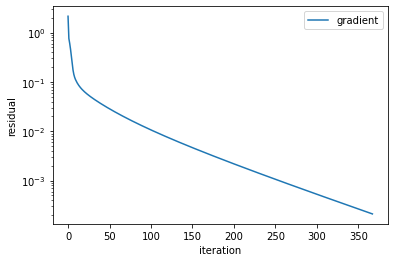

In [5]:
# Define a classification problem
X, y = create_classification_problem(100, 10, cond_number=10)
# Define the logistic loss function, and its gradient
f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)
# Pick the initial guess
w0 = zeros((10,1))

# Now, solve the minimization problem
w_g, res = grad_descent(f,grad,w0)

# Check the solution
assert res[-1]/res[0]<1e-4, "ERROR:  your gradient descent routine did not the minimize the function"
print("Solver terminated in %d steps"%len(res))
print("Terrific!  Your routine works!")

#x,res_g = grad_descent(f,grad,w0)
n_g = list(range(len(res)))
plt.semilogy(n_g,res)
plt.legend(('gradient',))
plt.xlabel('iteration')
plt.ylabel('residual')
plt.show()

### Now, implement a gradient solver that begins each iterations using a Barzilai-Borwein stepsize 
  $$\tau = \frac{\langle x^{k+1} - x^k ,x^{k+1} - x^k   \rangle}{\langle x^{k+1} - x^k ,\nabla f(x^{k+1}) - \nabla f(x^k)   \rangle}.$$
  Your routine should perform only 1 gradient computation per iteration (i.e., your method should not require any "extra" work).



In [6]:
def grad_descent_bb(f, grad, x0, max_iters=10000, tol=1e-4):
    
    alpha = 0.1
    xk = x0
    d = -grad(xk)
    tau = 10/estimate_lipschitz(f, x0)
    xk1 = xk + tau*d

    k = 0
    res = []
    res.append(norm(d))
    Boolean = True
    
    while k <= max_iters and Boolean == True:
        
        num = np.vdot(xk1 - xk, xk1 - xk)
        den = np.vdot(xk1 - xk, grad(xk1) - grad(xk))
        tau = num/den
        
        while f(xk1) > f(xk) + alpha*np.vdot(xk1 - xk,grad(xk)):
            
            tau = tau/2
            xk1 = xk + tau*d
        
        xk1 = xk + tau*d
        
        xk = xk1
        d = -grad(xk)
        xk1 = xk + tau*d
        
        res.append(norm(d))
        k = k + 1
        
        if norm(d)/norm(grad(x0)) < tol:
            
            Boolean = False
    
    return xk, res

### Now run this unit test

Solver terminated in 228 steps
Terrific!  Your BB routine works!


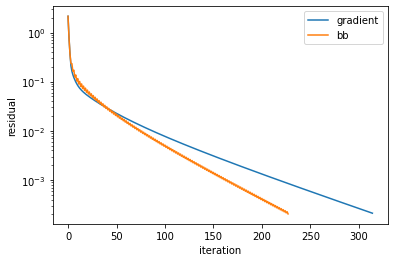

In [10]:
# Minimize that logistic loss again
f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)

w, res = grad_descent_bb(f,grad,w0)
assert res[-1]/res[0]<1e-4, "ERROR:  Your BB routine did not the minimize the function"
print("Solver terminated in %d steps"%len(res))
print("Terrific!  Your BB routine works!")

_, res_g = grad_descent(f,grad,w0)
_, res_b = grad_descent_bb(f,grad,w0)
n_g = list(range(len(res_g)))
n_b = list(range(len(res_b)))

plt.semilogy(n_g,res_g,n_b,res_b)
plt.legend(('gradient','bb'))
plt.xlabel('iteration')
plt.ylabel('residual')
plt.show()

### Write a routine that uses Nesterov's accelerated gradient method
\begin{align}
x^{k} &= y^k - \tau \nabla f(y^k)\\
\delta^{k+1} &= \frac{1+\sqrt{1+4(\delta^k)^2}}{2}\\
y^{k+1} &= x^{k}+\frac{\delta^k-1}{\delta^{k+1}}(x^k-x^{k-1})
\end{align}
The stepsize restriction for Nesterov's methods is $\tau<1/L,$ however when $L$ is not known exactly you can use the line search condition
 $$f(x^k) \le f(y^{k}) + \alpha (x^k-y^k)^T\nabla f(y^k), $$
 where $\alpha \in [1/2,1).$  I suggest choosing $\alpha=1/2.$

In [11]:
def grad_descent_nesterov(f, grad, x0, max_iters=10000, tol=1e-4):
    
    alpha = 1/2
    xkm1 = x0
    yk = x0
    delk = 1
    d = -grad(yk)
    tau = 10/estimate_lipschitz(f, x0)

    k = 0
    res = []
    res.append(norm(d))
    Boolean = True
    
    while k <= max_iters and Boolean == True:
        
        xk = yk + tau*d
        
        while f(xk) > f(yk) + alpha*np.vdot(xk - yk,-d):
            
            tau = tau/2
            xk = yk + tau*d
            
        xk = yk + tau*d
        
        delk1 = (1 + sqrt(1 + 4*delk*delk))/2
        yk1 = xk + ((delk - 1)/delk1)*(xk - xkm1)
        
        xkm1 = xk
        yk = yk1
        delk = delk1
        d = -grad(yk)
        
        res.append(norm(d))
        k = k + 1
        
        if norm(d)/norm(grad(x0)) < tol:
            
            Boolean = False
    
    return xkm1, res

### Now run this unit test

Solver terminated in 194 steps
Terrific!  Your Nesterov routine works!


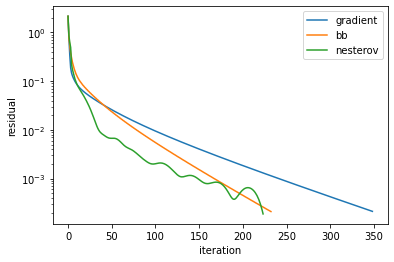

In [12]:
# Minimize the logistic loss using Nesterov's method
f = lambda w: logreg_objective(w,X,y)
grad = lambda w: logreg_objective_grad(w,X,y)

w, res = grad_descent_nesterov(f,grad,w0)
assert res[-1]/res[0]<1e-4, "ERROR:  Your Nesterov routine did not the minimize the function"
print("Solver terminated in %d steps"%len(res))
print("Terrific!  Your Nesterov routine works!")

_, res_g = grad_descent(f,grad,w0)
_, res_b = grad_descent_bb(f,grad,w0)
_, res_n = grad_descent_nesterov(f,grad,w0)
n_g = list(range(len(res_g)))
n_b = list(range(len(res_b)))
n_n = list(range(len(res_n)))

plt.semilogy(n_g,res_g,n_b,res_b,n_n,res_n)
plt.legend(('gradient','bb','nesterov'))
plt.xlabel('iteration')
plt.ylabel('residual')
plt.show()

# Problem 2:  Image denoising
Consider this noisy test image.

Here is a noisy image...


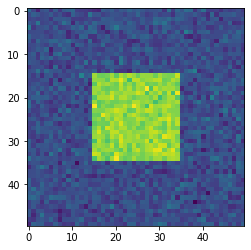

In [13]:
# Don't modify this block
image = zeros((50,50))
image[15:35,15:35]=1
image = image+0.1*randn(50,50)
print('Here is a noisy image...')
plt.imshow(image)
plt.show()

#### Here's the TV loss function from a previous homework...

In [14]:
# Don't modify this block
mu = .1
def h(z, eps=.01):
    """The hyperbolic approximation to L1"""
    return sum(sqrt(z*z+eps*eps).ravel())
def tv_denoise_objective(x,mu,b):
    return mu*h(grad2d(x)) + 0.5*norm(x-b)**2
def h_grad(z, eps=.01):
    """The gradient of h"""
    return z/sqrt(z*z+eps*eps)
def tv_denoise_grad(x,mu,b):
    """The gradient of the TV objective"""
    return mu*divergence2d(h_grad(grad2d(x))) + x-b

### Use your BB solver to minimize the TV objective, and denoise the test image.

Here's the denoised image...


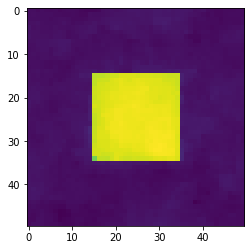

In [15]:
f = lambda x: tv_denoise_objective(x,mu,image)
grad = lambda x: tv_denoise_grad(x,mu,image)
x0 = np.zeros_like(image)

x, res = grad_descent_bb(f, grad, x0, max_iters=10000, tol=1e-4)

# Don't modify the three lines below
print("Here's the denoised image...")
plt.imshow(x)
plt.show()

# Problem 3:  The dual
Consider the "monotropic" program
\begin{align}
\text{minimize} & \quad  \|x\|_\infty \\
\text{subject to} & \quad Ax=b . \nonumber
\end{align}

Write this as an unconstrained (or implicitly constrained) problem using the characteristic function of the zero vector $\chi_0(z) .$  This function is zero if it's argument is zero, and infinite otherwise.



$$
\min_{x} \|x\|_\infty + \chi_0(Ax - b).
$$

#### What is the conjugate of $f(z)= \|z\|_\infty$?

We have,

$$
\|\|^{*}_\infty(y)
=
\sup_{z} y^{T} z - \|z\|_\infty.
$$

Using dual norms and Holder's inequality, we have $| y^{T} z | \leq \|y\|_1 \|z\|_\infty$. First let $\|y\|_1 < 1$. By Holder's Inequality, $y^{T} z \leq \|y\|_1 \|z\|_\infty$ and the RHS is at most  $\|z\|_\infty ( \|y\|_1 - 1 )$. Then the RHS is $\leq 0$ and can be made $0$ by taking $z = 0$. 

Now let $\|y\|_1 > 1$. Let $1 \leq k \leq n$ be the smallest integer such that $|y_1| + \cdots + |y_k| > 1$. Let $z = t(\pm 1, \cdots, \pm 1, 0, \cdots, 0)$, such that $t > 0$, the first $k$ components of $z$ are $\pm 1$, and a component is $+1 \; (-1)$ if and only if the corresponding component in $y$ is positive (negative). Hence we have 
$y^{T} z - \|z\|_\infty = t ( |y_1| + \cdots + |y_k| - 1)$. This goes to infinity as $t$ goes to $+ \infty$.

Hence we have,

$$
\|\|^{*}_\infty(y)
= 0 \; \text{if} \; \|y\|_1 \leq 1,
\quad 
\|\|^{*}_\infty(y)
= + \infty \; \text{if} \; \|y\|_1 > 1.
$$

#### What is the conjugate of $g(z)=\chi_0(z)$?

We have,

$$
\chi^{*}_0(y)
=
\sup_{z} y^{T} z - \chi_0(z).
$$

If $y = 0$, the supremum on the RHS is zero (just pick a non-zero $z$). If $y \neq 0$, then every $z$ can be expressed as $z = \alpha y + x$ such that $\alpha \in \mathbf{R}$ and $x$ is orthogonal to $y$. We then have that the RHS is $-1$ if $z = 0$ and is $\alpha \| y \|^2$ for $z \neq 0$. The RHS is clearly unbounded in this case (just let $\alpha$ go to $+ \infty$.). Hence we have,

$$
\chi^{*}_0(y)
= 0 \; \text{if} \; y = 0,
\quad 
\chi^{*}_0(y)
= + \infty \; \text{if} \; y \neq 0.
$$

#### Using the conjugate functions, write down the dual of the monotropic problem.

We derive the dual of the monotropic problem in terms of the conjugate functions. The Lagrangian is given by,

$$
L( x, \lambda )
=
\|x\|_\infty + \lambda^T (Ax - b).
$$

The dual function is,

$$
g(\lambda)
=
\inf_x \|x\|_\infty + \lambda^T (Ax - b)
=
- \lambda^T b + \inf_x (  \|x\|_\infty + \lambda^T Ax )
=
- \lambda^T b - \sup_x (  - \|x\|_\infty + (- A^T \lambda )^Tx )
=
- \lambda^T b - \|\|^{*}_\infty( - A^T \lambda ).
$$

Using the result in (a), we have,

$$
g(\lambda)
= - \lambda^T b \; \text{if} \; \|A^T \lambda\|_1 \leq 1,
\quad 
g(\lambda)
= - \infty \; \text{if} \; \|A^T \lambda\|_1 > 1.
$$


# Problem 4:  Linear programming
Consider the linear program
\begin{align*}
\text{minimize} \quad &  c^T x \\
\text{subject to} \quad & Ax=b\\
 & x\ge 0.
\end{align*}

#### Write the optimality conditions for this problem (i.e., the KKT system).

Let $x^*$ be an optimal point. The KKT conditions are:

\begin{align*}
Ax^* - b = 0, -x^* \leq 0, \quad \text{primal fesibility}, \\
\lambda \geq 0, \quad \text{dual fesibility}, \\
c + A^T = \lambda, \quad \text{dual optimality}, \\
-\nu^T x^*, \quad \text{complemntary slackness}.
\end{align*}

See the Lagrangian below.

#### Write the Lagrangian for this problem.

The Lagrangian is given by,

$$
L(x, \lambda, \nu) = c^T x + \nu^T (Ax - b) - \lambda^T x
=
- \nu^T b + (c + A^T \nu - \lambda )^Tx.
$$

#### Minimize out the primal variables in the Lagrangian, and write the dual formulation of this linear program.

The dual function is,

$$
g(\lambda, \nu) = \inf_x L(x, \lambda, \nu) = - \nu^T b + \inf_x \; (c + A^T \nu - \lambda )^Tx.
$$

Since the we function in $x$ is affine, we have,

$$
g(\lambda, \nu)
= - \nu^T b \; \text{if} \; c + A^T \nu - \lambda = 0,
\quad 
g(\lambda, \nu)
= - \infty \; \text{otherwisse} \;.
$$

The Lagrange dual problem is,

$$
\max_{\lambda, \nu} g(\lambda, \nu)
\quad 
\text{such that}
\quad 
\lambda \succeq 0.
$$

Now $g(\lambda, \nu)$ is finite and satisfies the constraint of the dual problem if and only if $c + A^T \nu = \lambda \succeq 0$. Hence the dual problem is,

$$
\max_{\nu}
- \nu^T b
\quad
\text{such that}
\quad 
\lambda = c + A^T \nu \succeq 0.
$$